# 코스피 200, 코스닥 150 종목 간의 상관관계 및 인과관계 분석(Correlation and causal analysis between KOSPI 200 and KOSDAQ 150 stocks)

In [22]:
from pykrx import stock # 네이버금융/한국거래소 데이터를 이용하는 API 사용
import yfinance as yf

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

In [40]:
# 원하는 지수의 인덱스 번호 찾기
for i in range(10000):
    try:
        # print(stock.get_index_ticker_name(f'{str(i)}'))
        if(stock.get_index_ticker_name(f'{str(i)}')) == '코스닥 150':
            print(f'지수의 인덱스: {str(i)}')
            break
    except Exception as e:
        continue

지수의 인덱스: 2203


In [25]:
### 특정 크기 이상의 KOSPI200과 KOSDAQ150 종목들의 집합 데이터 생성
'''
idx: 지수의 인덱스
'''
def stockdata_gen(idx):
    if idx == "1028":
        market_ticker = "KS"
    elif idx == "2203":
        market_ticker = "KQ"
        
    stock_data = {}
        
    for ticker in stock.get_index_portfolio_deposit_file(idx):
        stock_name = stock.get_market_ticker_name(ticker)
        data = yf.download(f'{ticker}.{market_ticker}', start='2016-01-01', end='2023-06-14', interval='1d') # Valid intervals: 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo
        data.dropna(inplace=True)
        if len(data) > 1200:
            stock_data[stock_name] = data
        
    return stock_data

In [26]:
kospi200 = stockdata_gen("1028")
kosdaq150 = stockdata_gen("2203")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [27]:
### DataFrame들의 DateTimeIndex 교집합 구하는 함수(날짜 맞추기)
def common_length(stock_dict):
    common_index = None
    for df in stock_dict.values():
        if common_index is None:
            common_index = df.index
        else:
            common_index = common_index.intersection(df.index)

    # 교집합을 기반으로 DataFrame들을 구성하여 새로운 딕셔너리에 추가
    common_dataframes = {}
    for key, df in stock_dict.items():
        common_dataframes[key] = df.loc[common_index]
        
    return common_dataframes

In [28]:
# KOSPI200과 KOSDAQ150 데이터 합친 데이터 생성
total_stock = {}
total_stock.update(kospi200)
total_stock.update(kosdaq150)

In [29]:
aligned_stock = common_length(total_stock)
aligned_stock

{'삼성전자':                Open     High      Low    Close     Adj Close    Volume
 Date                                                                  
 2018-07-13  45800.0  46500.0  45750.0  46500.0  40456.359375  11543389
 2018-07-16  46800.0  46800.0  46000.0  46050.0  40064.839844   7678719
 2018-07-17  46150.0  46200.0  45600.0  45850.0  39890.847656   8892953
 2018-07-18  46700.0  47200.0  46450.0  46550.0  40499.851562  10952645
 2018-07-19  47050.0  47200.0  46600.0  46900.0  40804.371094   9880128
 ...             ...      ...      ...      ...           ...       ...
 2023-06-07  71300.0  71600.0  70800.0  71000.0  71000.000000  14796613
 2023-06-08  70400.0  70900.0  70000.0  70900.0  70900.000000  19165568
 2023-06-09  71100.0  72300.0  70800.0  72000.0  72000.000000  15050209
 2023-06-12  72100.0  72400.0  70800.0  71000.0  71000.000000  12064287
 2023-06-13  71700.0  72200.0  71600.0  72000.0  72000.000000  13227285
 
 [808 rows x 6 columns],
 'SK하이닉스':                 Op

In [30]:
### 종목간의 상관관계 히트맵 그리는 함수
'''
stocks: 주가 데이터
ohlcv: Open, High, Low, Close, Adj Close, Volume 중 선택
method: pearson, spearman, kendall 중 선택
'''
def CorrHeatmap(stocks, ohlcv, method):
    dataframes = list(stocks.values())
    data = [df[f'{ohlcv}'] for df in dataframes]
    # names = list(aligned_stock.keys())
    correlation_matrix = pd.concat(data, axis=1).corr(method=method)

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", xticklabels=False, yticklabels=False)
    # sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", xticklabels=names, yticklabels=names)
    plt.title("Correlation Heatmap")
    plt.show()

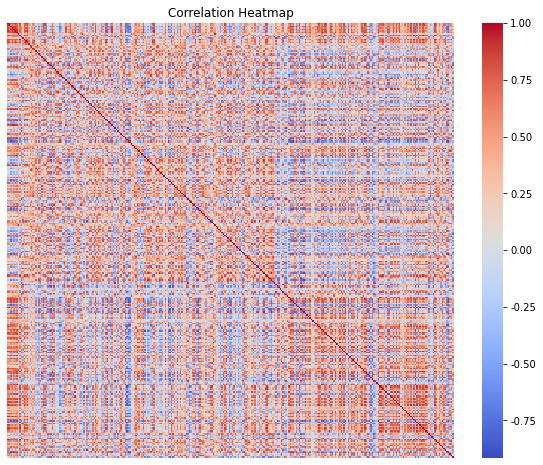

In [31]:
CorrHeatmap(aligned_stock, 'Close', 'pearson')

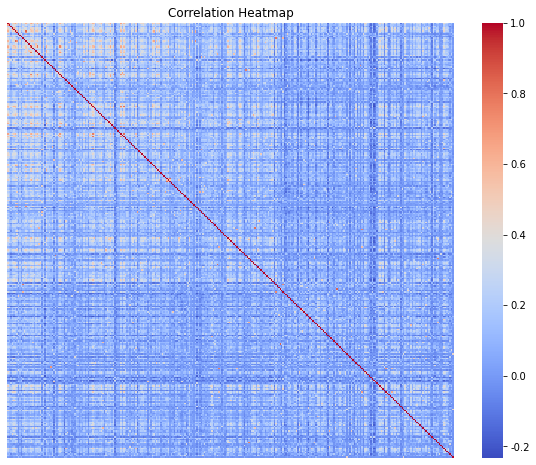

In [32]:
CorrHeatmap(aligned_stock, 'Volume', 'pearson')

In [33]:
### 종목간의 상관관계 계산 및 출력/저장하는 함수
'''
stocks: 주가 데이터
ohlcv: Open, High, Low, Close, Adj Close, Volume 중 선택
level: 상관계수 level 이상 값으로 출력 및 저장
method: pearson, spearman, kendall 중 선택
data_save: True-출력 및 저장, False- only 츨력
'''
def CorrCaculate(stocks, ohlcv, level, method, data_save):
    dataframes = list(stocks.values())
    data = [df[f'{ohlcv}'] for df in dataframes]
    names = list(stocks.keys())

    correlation_matrix = pd.concat(data, axis=1)
    correlation_matrix.columns = names
    correlation_matrix = correlation_matrix.corr(method=method)

    corr_data = {}
    # 상관관계를 내림차순으로 정렬하여 출력
    for name in names:
        print(f"[{name}]")

        individual_corr = []
        correlations = correlation_matrix[name].drop(name).sort_values(ascending=False)
        for target_name, corr in correlations.items():
            if abs(corr) >= level:
                individual_corr.append([target_name, corr])
                print(f"- {target_name}: {corr}")
        corr_data[name] = individual_corr
        print()

    if data_save:
        return corr_data

In [34]:
close_corr = CorrCaculate(aligned_stock, 'Close', 0.7, 'pearson', True)

[삼성전자]
- LB세미콘: 0.9369916576967222
- LG전자: 0.9327128776721174
- SK하이닉스: 0.9281827692221447
- 두산테스나: 0.9258175546086074
- 원익IPS: 0.9212969276740117
- 에프에스티: 0.9197443578842899
- 현대차: 0.913771068911918
- 인선이엔티: 0.9107324015964172
- 유진테크: 0.9062551373712797
- SFA반도체: 0.900944997263761
- 삼성전기: 0.8941252349083751
- 티씨케이: 0.8924610012215092
- HL만도: 0.8920103540353801
- 금호석유: 0.8845191336766434
- 이오테크닉스: 0.8805378385618017
- LG화학: 0.8757893737689704
- 보령: 0.8755714304867505
- 네패스: 0.8650750095994761
- 테스: 0.8614214103256052
- 아이에스동서: 0.859258233005992
- NAVER: 0.8589129998752203
- 서진시스템: 0.8540555247362316
- 상아프론테크: 0.8539415534151976
- 카카오: 0.8536601636954614
- 현대위아: 0.8513250461261659
- 코미코: 0.8504843518016443
- 유한양행: 0.8483463094382125
- 세방전지: 0.8450592677542975
- 씨에스윈드: 0.8436231741443903
- 티에스이: 0.8434080661055968
- DB하이텍: 0.8417759777715854
- 에스티팜: 0.8389212464679964
- 리노공업: 0.8388121541676302
- 기아: 0.8297167471890351
- 삼성SDI: 0.8230502640792225
- 지씨셀: 0.811807120929272
- 키움증권: 0.810394

In [35]:
volume_corr = CorrCaculate(aligned_stock, 'Volume', 0.5, 'pearson', True)

[삼성전자]
- SK하이닉스: 0.6676740405218973
- 삼성증권: 0.6653949304030844
- 신한지주: 0.6542654660336537
- 현대차: 0.6223922099099699
- GS: 0.6196567253948376
- 현대모비스: 0.6032056409788117
- 미래에셋증권: 0.5929523855535327
- 기업은행: 0.5921404606310355
- 하나금융지주: 0.5874432247891814
- KB금융: 0.587257445092266
- 삼성화재: 0.5832447043093479
- NH투자증권: 0.5593668564798187
- CJ제일제당: 0.5509482692064148
- KT&G: 0.5437399147637882
- 현대제철: 0.5319673049424067
- 키움증권: 0.530781332483997
- 삼성SDI: 0.5169894287164212
- SK이노베이션: 0.5074967711370801

[SK하이닉스]
- 삼성전자: 0.6676740405218973

[삼성바이오로직스]

[LG화학]
- 삼성SDI: 0.5915052178572271

[삼성SDI]
- 미래에셋증권: 0.5980893408699034
- LG화학: 0.5915052178572271
- KB금융: 0.5640979065115223
- 기업은행: 0.5176403383961333
- 삼성전자: 0.5169894287164212
- 하나금융지주: 0.5169583096028993
- NH투자증권: 0.5096870129504641
- 삼성증권: 0.5025072128230154

[현대차]
- 현대모비스: 0.8383031679530629
- HL만도: 0.6475187829126792
- 삼성전자: 0.6223922099099699
- 현대위아: 0.6154824665565213
- 기아: 0.5984143927090902
- 미래에셋증권: 0.5901154411372853
- 삼성증권: 0.5

In [39]:
for close_key, close_value in close_corr.items():
    for volume_key, volume_value in volume_corr.items():
        if close_key == volume_key and close_key and volume_key:
            for i in close_value:
                for j in volume_value:
                    if i[0] == j[0] and (i[1] > 0 and j[1] > 0):
                        print(f'[{close_key} <-> {i[0]}] Close:{i[1]}, Volume:{j[1]}')

[삼성전자 <-> SK하이닉스] Close:0.9281827692221447, Volume:0.6676740405218973
[삼성전자 <-> 현대차] Close:0.913771068911918, Volume:0.6223922099099699
[삼성전자 <-> 삼성SDI] Close:0.8230502640792225, Volume:0.5169894287164212
[삼성전자 <-> 키움증권] Close:0.810394715443939, Volume:0.530781332483997
[삼성전자 <-> 현대모비스] Close:0.8074638786934574, Volume:0.6032056409788117
[삼성전자 <-> 삼성증권] Close:0.8000544711660055, Volume:0.6653949304030844
[삼성전자 <-> 미래에셋증권] Close:0.7045528141921894, Volume:0.5929523855535327
[SK하이닉스 <-> 삼성전자] Close:0.9281827692221447, Volume:0.6676740405218973
[LG화학 <-> 삼성SDI] Close:0.8633139539676837, Volume:0.5915052178572271
[삼성SDI <-> LG화학] Close:0.8633139539676837, Volume:0.5915052178572271
[삼성SDI <-> 삼성전자] Close:0.8230502640792225, Volume:0.5169894287164212
[현대차 <-> HL만도] Close:0.9330342917768792, Volume:0.6475187829126792
[현대차 <-> 삼성전자] Close:0.913771068911918, Volume:0.6223922099099699
[현대차 <-> 기아] Close:0.9015254105371447, Volume:0.5984143927090902
[현대차 <-> 현대위아] Close:0.8980177113110306, Volume

In [36]:
### 종목간의 그레인저 인과관계 계산 및 출력/저장하는 함수
'''
stocks: 주가 데이터
ohlcv: Open, High, Low, Close, Adj Close, Volume 중 선택
level: 유의수준 설정(0.05 or 0.01)
lag: 지연시킬 lag 설정
data_save: True-출력 및 저장, False- only 츨력
'''
def GrangerCausalityTest(stocks, ohlcv, level, lag, data_save):
    dataframes = list(stocks.values())
    names = list(stocks.keys())
    results = {}
    
    for i, name in enumerate(names):
        results[name] = {}
        
        for j in range(i + 1, len(names)):
            granger_test = grangercausalitytests(
                pd.concat([dataframes[i][f'{ohlcv}'], dataframes[j][f'{ohlcv}']], axis=1),
                maxlag=lag,
                verbose=False
            )
            p_value = granger_test[lag][0]['ssr_ftest'][1]
            results[name][names[j]] = round(p_value, 4)

    granger_data = {}
    for name, result in results.items():
        print(f"[{name}]")
        sorted_results = sorted(result.items(), key=lambda x: x[1])
        individual_granger = []
        for target_name, p_value in sorted_results:
            if p_value < level:
                individual_granger.append([target_name, p_value])
                print(f"- {target_name} (p-value={p_value})")
        granger_data[name] = individual_granger
        print()

    if data_save:
        return granger_data

In [37]:
granger_1 = GrangerCausalityTest(aligned_stock, 'Close', 0.05, 1, True)

[삼성전자]
- S-Oil (p-value=0.0001)
- 셀트리온제약 (p-value=0.0002)
- GS (p-value=0.0003)
- 영풍 (p-value=0.0003)
- 한국가스공사 (p-value=0.0004)
- 신한지주 (p-value=0.0005)
- 현대해상 (p-value=0.0008)
- 파라다이스 (p-value=0.0009)
- KCC (p-value=0.001)
- 강원랜드 (p-value=0.0012)
- PI첨단소재 (p-value=0.0015)
- 서부T&D (p-value=0.0015)
- BNK금융지주 (p-value=0.0016)
- 원익머트리얼즈 (p-value=0.0017)
- 롯데칠성 (p-value=0.0024)
- 에스앤에스텍 (p-value=0.0026)
- 하나금융지주 (p-value=0.0028)
- 한화 (p-value=0.0028)
- 상상인 (p-value=0.0028)
- 팬오션 (p-value=0.0032)
- KB금융 (p-value=0.0044)
- 알테오젠 (p-value=0.0046)
- OCI홀딩스 (p-value=0.0048)
- SK이노베이션 (p-value=0.005)
- 코오롱인더 (p-value=0.0059)
- 에프에스티 (p-value=0.006)
- 하나투어 (p-value=0.0062)
- 에스에프에이 (p-value=0.0067)
- 삼천당제약 (p-value=0.0069)
- 대한항공 (p-value=0.007)
- 서진시스템 (p-value=0.0071)
- 롯데웰푸드 (p-value=0.0073)
- 포스코인터내셔널 (p-value=0.0074)
- DGB금융지주 (p-value=0.008)
- BGF리테일 (p-value=0.0086)
- 종근당 (p-value=0.009)
- 티케이케미칼 (p-value=0.0093)
- 기업은행 (p-value=0.0094)
- KT (p-value=0.0094)
- 이엠텍 (p-value=0.0098)
- 제일기획 (p-